In [1]:
#Import Packages Needed for Analysis
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [2]:
xls = pd.ExcelFile('fundamental_data.xlsx') #Read Excel File
gics_data = pd.read_excel('gics_hierarchy.xlsx') #Read GICS Sector/Industry Data to DF
gics_data['Ticker'] = gics_data['Ticker'].astype(str)

In [3]:
frames = [] #Initialize list to hold each df per excel tab
for i in range(2,827): #Loop through numbers of tabs in excel spreadsheet
    df_temp = pd.read_excel(xls,'stock' + str(i)) #Create df for first each iteration
    ticker = df_temp.columns[1] #Obtain ticker for respective stock
    new_header = df_temp.iloc[0] #Create a new header based on what stock we are analyzing
    df_temp = df_temp[1:] #Add ticker variable into list, so we can keep all the information after loop finished
    df_temp.columns=new_header #Set the df based on updated headers with stock concatenation
    df_temp['Ticker'] = ticker #Create new column for ticker
    df_temp['Ticker'].astype(str) #Set ticker as a string instead of object class
    df_temp = df_temp.drop(df_temp.index[0]) 
    df_temp.rename(columns = {np.nan:'Date'}, inplace = True)
    df_temp['Year'] = pd.DatetimeIndex(df_temp['Date']).year #Add a year column
    df_temp['Month'] = pd.DatetimeIndex(df_temp['Date']).month #Add a month column
    df_temp['Total Earnings'] = df_temp['Basic Earnings per Share'] * df_temp['Current Shares Outstanding'] #Earnings column
    df_temp['Total Dividends'] = df_temp['Dividends per Share'] * df_temp['Current Shares Outstanding'] #Dividends column
    df_temp['Total Book Value'] = df_temp['Book Value per Share'] * df_temp['Current Shares Outstanding'] #Book Value column
    df_temp.drop(columns = ['Date'],axis = 1, inplace = True) #Drop Date column
    df_temp.drop(df_temp.index[0], inplace = True)#Drop indexed row 0 
    frames.append(df_temp) #add df into list in order to merge into master df
df = pd.concat(frames, sort=False, ignore_index = True) #Concatenate all df into one master df
df.head(3)

,Revenue,Gross Profit,Net Income/Net Profit (Losses),EBIT,EBITDA,Total Assets,Total Liabilities,Cash and Cash Equivalents,Total Short Term Debt,Current Market Cap,...,Book Value per Share,Free Cash Flow,Dividends Paid,Dividends per Share,Ticker,Year,Month,Total Earnings,Total Dividends,Total Book Value
0,297.697,72.764,21.342,34.976,50.834,820.616,378.94,40.153,NaN,1777,...,9.3374,-4.511,0,0,MTZ US Equity,2000.0,6.0,21.4273,0,434.945
1,382.279,88.928,25.088,47.121,63.094,937.358,450.338,53.322,NaN,1466.35,...,10.2311,-10.323,0,0,MTZ US Equity,2000.0,9.0,25.0701,0,483.951
2,377.626,86.961,7.24,44.671,59.316,956.345,456.017,18.457,NaN,952.048,...,10.4849,-30.567,0,0,MTZ US Equity,2000.0,12.0,7.1403,0,499.102


In [4]:
print(df.shape) #Shape of raw data
print(df.isna().sum()) #Sum of NA's per feature
df.drop(columns = ['Total Short Term Debt'],axis = 1, inplace = True) #Drop column with all NA's
df.dropna(how = 'any',inplace = True) #Drop rest of rows with NA;s
df = df[df['EBIT'] > 0] #Only look at rows with positive EBIT
df = df[df['Revenue'] > 0] #Only look at rows with positive EBIT
df['EBIT Margin'] = df['EBIT'] / df['Revenue'] #Create new EBIT margin coluumn 
df['EBITDA Margin'] = df['EBITDA'] / df['Revenue'] #Create new EBITDA margin column
df.reset_index(inplace = True, drop = True) #Reset Index
df.shape #42K and 24 olumns in remaining DF

(64259, 23)
0
Revenue                            3625
Gross Profit                      14254
Net Income/Net Profit (Losses)     3621
EBIT                              10127
EBITDA                            10454
Total Assets                       3680
Total Liabilities                  3682
Cash and Cash Equivalents          3681
Total Short Term Debt             64259
Current Market Cap                 3851
Basic Earnings per Share           3875
Current Shares Outstanding         3881
Enterprise Value                   7809
Book Value per Share               3915
Free Cash Flow                     3794
Dividends Paid                     4162
Dividends per Share                3924
Ticker                                0
Year                                 10
Month                                10
Total Earnings                     4198
Total Dividends                    4281
Total Book Value                   4214
dtype: int64


(42579, 24)

In [5]:
#Merge data with gics hierarchy df
df = pd.merge(left=df,right=gics_data,on = 'Ticker', how = 'inner')
df.head(3)

,Revenue,Gross Profit,Net Income/Net Profit (Losses),EBIT,EBITDA,Total Assets,Total Liabilities,Cash and Cash Equivalents,Current Market Cap,Basic Earnings per Share,...,Month,Total Earnings,Total Dividends,Total Book Value,EBIT Margin,EBITDA Margin,Name,GICS Sector,GICS Ind Grp Name,GICS Ind Name
0,297.697,72.764,21.342,34.976,50.834,820.616,378.94,40.153,1777,0.46,...,6.0,21.4273,0,434.945,0.117489,0.170758,MASTEC INC,Industrials,Capital Goods,Construction & Engineering
1,382.279,88.928,25.088,47.121,63.094,937.358,450.338,53.322,1466.35,0.53,...,9.0,25.0701,0,483.951,0.123263,0.165047,MASTEC INC,Industrials,Capital Goods,Construction & Engineering
2,377.626,86.961,7.24,44.671,59.316,956.345,456.017,18.457,952.048,0.15,...,12.0,7.1403,0,499.102,0.118294,0.157076,MASTEC INC,Industrials,Capital Goods,Construction & Engineering


In [6]:
dict_of_sector = {_: x for _, x in df.groupby('GICS Sector') if len(x) >=1000} #Create dictionary of new dfs by sector
dict_of_ind_grp = {_: x for _, x in df.groupby('GICS Ind Grp Name')if len(x) >=1000} #Create dictionary of new df's by industry_group

In [7]:
print(dict_of_sector.keys()) #Look at sector categories
dict_of_ind_grp.keys() #Look at industry group categories

dict_keys(['Communication Services', 'Consumer Discretionary', 'Consumer Staples', 'Energy', 'Health Care', 'Industrials', 'Information Technology', 'Materials', 'Utilities'])


dict_keys(['Capital Goods', 'Commercial & Professional Services', 'Consumer Durables & Apparel', 'Consumer Services', 'Energy', 'Food, Beverage & Tobacco', 'Health Care Equipment & Services', 'Materials', 'Pharmaceuticals, Biotechnology & Life Sciences', 'Retailing', 'Semiconductors & Semiconductor Equipment', 'Software & Services', 'Technology Hardware & Equipment', 'Utilities'])

In [8]:
dfs_sect = {} #Initialize dictionary
for i in dict_of_sector.keys():
    dfs_sect[i] = dict_of_sector[i][['Revenue','Current Market Cap']] #Create new sector df's with only revenue and market cap
dfs_ind_grp = {}
for i in dict_of_ind_grp.keys():
    dfs_ind_grp[i] = dict_of_ind_grp[i][['Revenue','Current Market Cap']] #Create new industry group df's with only revenue and market cap

In [9]:
#Train Simple Linear regression for all sectors by only looking at revenue
coefs = []
scores = []
sector = []
cepts = []
rows = []
for i in dict_of_sector.keys():
    X = dfs_sect[i].iloc[:,:-1]
    y = dfs_sect[i].iloc[:,-1]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=20)
    reg = LinearRegression().fit(X_train, y_train)
    y_lr_pred = reg.predict(X_test)
    coefs.append(round(reg.coef_[0],2))
    scores.append(r2_score(y_test,y_lr_pred))
    sector.append(i)
    cepts.append(round(reg.intercept_,2))
    rows.append(len(X))
df_sect_dict = {"Sector":sector,'Data Points':rows,"Revenue Multiple":coefs, "% of Valuation Explained": scores,"Intercept": cepts}
df_sect = pd.DataFrame(df_sect_dict)

In [10]:
#Revenue can historically explain 64% of valuation with industrials receiving a 3.12 multiple
df_sect.sort_values(by = '% of Valuation Explained', inplace = True, ascending = False)
df_sect['% of Valuation Explained'] = round(df_sect['% of Valuation Explained'] * 100,2).astype(str) +"%"
df_sect.reset_index(inplace = True, drop = True)
df_sect

,Sector,Data Points,Revenue Multiple,% of Valuation Explained,Intercept
0,Industrials,8816,3.12,64.78%,1347.06
1,Communication Services,1325,4.44,59.05%,2202.50
2,Materials,2936,3.72,47.29%,762.11
3,Utilities,2225,4.73,46.64%,1043.29
4,Information Technology,8641,2.93,45.48%,3043.07
5,Energy,2196,1.70,40.93%,6813.49
6,Consumer Discretionary,7858,1.59,27.85%,4039.39
7,Consumer Staples,3042,2.29,19.35%,5661.53
8,Health Care,4882,0.80,16.9%,6494.23


Text(0.5, 1.0, 'Revenue Regression for Industrials at 64.78% R^2')

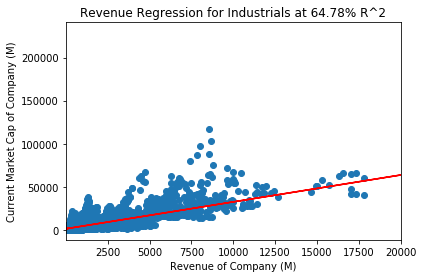

In [11]:
#View 2d regression of revenue and current market cap for industrials
plt.scatter(dfs_sect[df_sect['Sector'][0]]['Revenue'], dfs_sect[df_sect['Sector'][0]]['Current Market Cap'])
plt.plot(dfs_sect[df_sect['Sector'][0]]['Revenue'], (df_sect['Revenue Multiple'][0]*dfs_sect[df_sect['Sector'][0]]['Revenue'])+df_sect['Intercept'][0], color='red')
plt.xlim(min(dfs_sect[df_sect['Sector'][0]]['Revenue']),20000)
plt.xlabel('Revenue of Company (M)')
plt.ylabel('Current Market Cap of Company (M)')
plt.title('Revenue Regression for {} at {} R^2'.format(df_sect['Sector'][0],df_sect['% of Valuation Explained'][0]))

In [12]:
#Train Simple Linear Regression for all industry groups by only looking at revenue
coefs = []
scores = []
sector = []
cepts = []
rows = []
for i in dict_of_ind_grp.keys():
    X = dfs_ind_grp[i].iloc[:,:-1]
    y = dfs_ind_grp[i].iloc[:,-1]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=20)
    reg = LinearRegression().fit(X_train, y_train)
    y_lr_pred = reg.predict(X_test)
    coefs.append(round(reg.coef_[0],2))
    scores.append(r2_score(y_test,y_lr_pred))
    sector.append(i)
    cepts.append(round(reg.intercept_,2))
    rows.append(len(X))
df_ind_grp_dict = {"Sector":sector,'Data Points':rows,"Revenue Multiple":coefs, "% of Valuation Explained": scores,"Intercept": cepts}
df_ind_grp = pd.DataFrame(df_ind_grp_dict)

In [13]:
#Revenue can historically explain 77% of valuation with Pharma receiving a very high 16.58 multiple
df_ind_grp.sort_values(by = '% of Valuation Explained', inplace = True, ascending = False)
df_ind_grp['% of Valuation Explained'] = round(df_ind_grp['% of Valuation Explained'] * 100,2).astype(str) +"%"
df_ind_grp.reset_index(inplace = True, drop = True)
df_ind_grp

,Sector,Data Points,Revenue Multiple,% of Valuation Explained,Intercept
0,"Pharmaceuticals, Biotechnology & Life Sciences",1439,16.58,77.73%,258.15
1,Consumer Services,2013,7.84,69.66%,-711.64
2,Semiconductors & Semiconductor Equipment,1939,9.07,66.94%,1443.35
3,Commercial & Professional Services,2072,6.75,58.84%,-150.55
4,Capital Goods,5877,3.00,57.88%,1390.18
5,Technology Hardware & Equipment,3312,2.67,57.38%,1282.39
6,Software & Services,3390,9.99,57.01%,782.67
7,"Food, Beverage & Tobacco",1773,4.50,47.46%,2894.21
8,Materials,2936,3.72,47.29%,762.11
9,Utilities,2225,4.73,46.64%,1043.29


Text(0.5, 1.0, 'Revenue Regression for Pharmaceuticals, Biotechnology & Life Sciences at 77.73% R^2')

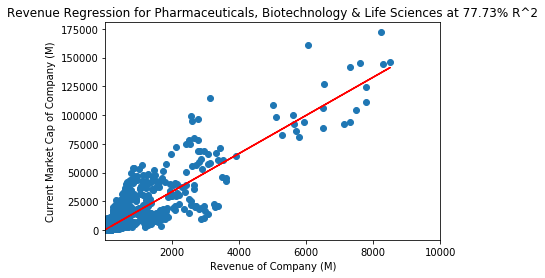

In [14]:
#View 2d regression of revenue and current market cap for Pharma
plt.scatter(dfs_ind_grp[df_ind_grp['Sector'][0]]['Revenue'], dfs_ind_grp[df_ind_grp['Sector'][0]]['Current Market Cap'])
plt.plot(dfs_ind_grp[df_ind_grp['Sector'][0]]['Revenue'], (df_ind_grp['Revenue Multiple'][0]*dfs_ind_grp[df_ind_grp['Sector'][0]]['Revenue'])+df_ind_grp['Intercept'][0], color='red')
plt.xlim(min(dfs_ind_grp[df_ind_grp['Sector'][0]]['Revenue']),10000)
plt.xlabel('Revenue of Company (M)')
plt.ylabel('Current Market Cap of Company (M)')
plt.title('Revenue Regression for {} at {} R^2'.format(df_ind_grp['Sector'][0],df_ind_grp['% of Valuation Explained'][0]))

In [15]:
#Create DFs with 4,10, and 14 features
dfs_ind_grp_5 = {}
for i in dict_of_ind_grp.keys():
    dfs_ind_grp_5[i] = dict_of_ind_grp[i][['Revenue','EBIT','EBITDA','Total Earnings','Gross Profit','Current Market Cap']]
    
dfs_ind_grp_10 = {}
for i in dict_of_ind_grp.keys():
    dfs_ind_grp_10[i] = dict_of_ind_grp[i][['Revenue','EBIT','EBITDA','Total Earnings','Gross Profit','Total Assets','Cash and Cash Equivalents','Total Dividends','Total Liabilities','Total Book Value','Current Market Cap']]
    
dfs_ind_grp_15 = {}
for i in dict_of_ind_grp.keys():
    dfs_ind_grp_15[i] = dict_of_ind_grp[i][['Revenue','EBIT','EBITDA','Total Earnings','Gross Profit','Total Assets','Cash and Cash Equivalents','Total Dividends','Total Liabilities','Total Book Value','Current Shares Outstanding','Free Cash Flow','EBIT Margin','EBITDA Margin','Year','Current Market Cap']]

In [16]:
#Train Multiple Linear Regression for 5 features on industry groups
train_scores = []
scores = []
sector = []
rows = []
adj_r2 = []
for i in dict_of_ind_grp.keys():
    X = dfs_ind_grp_5[i].iloc[:,:-1]
    y = dfs_ind_grp_5[i].iloc[:,-1]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=20)
    reg = LinearRegression().fit(X_train, y_train)
    y_lr_pred = reg.predict(X_test)
    scores.append(r2_score(y_test,y_lr_pred))
    train_scores.append(r2_score(y_train,reg.predict(X_train)))
    sector.append(i)
    rows.append(len(X_train))
    adj_r2.append(1- (1-r2_score(y_test,y_lr_pred)) * (len(X_test)-1) / (len(X_test)-len(X_test.columns)-1) )
df_ind_grp_dict_5 = {"Sector":sector,'Training Data Points':rows, "% of Valuation Explained": scores,'%Adj R2':adj_r2,'% Training Score':train_scores}
df_ind_grp_5 = pd.DataFrame(df_ind_grp_dict_5)

In [17]:
#Look at Adjusted R2 and Training Score due to increases dimensions 
#Pharma looks like it is benefiting from randomness going from training score of 82.78 to Adj R2 of 90.17
df_ind_grp_5.sort_values(by = '% of Valuation Explained', inplace = True, ascending = False)
df_ind_grp_5['% of Valuation Explained'] = round(df_ind_grp_5['% of Valuation Explained'] * 100,2).astype(str) +"%"
df_ind_grp_5['% Training Score'] = round(df_ind_grp_5['% Training Score'] * 100,2).astype(str) +"%"
df_ind_grp_5['%Adj R2'] = round(df_ind_grp_5['%Adj R2'] * 100,2).astype(str) +"%"
df_ind_grp_5.reset_index(inplace = True, drop = True)
df_ind_grp_5

,Sector,Training Data Points,% of Valuation Explained,%Adj R2,% Training Score
0,"Pharmaceuticals, Biotechnology & Life Sciences",1079,90.31%,90.17%,82.78%
1,Capital Goods,4407,80.24%,80.17%,81.9%
2,Energy,1647,80.04%,79.86%,82.57%
3,"Food, Beverage & Tobacco",1329,78.17%,77.92%,78.37%
4,Technology Hardware & Equipment,2484,77.45%,77.32%,83.43%
5,Commercial & Professional Services,1554,76.84%,76.62%,81.17%
6,Semiconductors & Semiconductor Equipment,1454,75.52%,75.26%,75.26%
7,Materials,2202,73.14%,72.96%,71.65%
8,Consumer Services,1509,72.44%,72.16%,71.27%
9,Health Care Equipment & Services,2582,72.35%,72.19%,72.25%


In [18]:
#Train Multiple Linear Regression for 10 features on industry groups
train_scores = []
scores = []
sector = []
rows = []
adj_r2 = []
for i in dict_of_ind_grp.keys():
    X = dfs_ind_grp_10[i].iloc[:,:-1]
    y = dfs_ind_grp_10[i].iloc[:,-1]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=20)
    reg = LinearRegression().fit(X_train, y_train)
    y_lr_pred = reg.predict(X_test)
    scores.append(r2_score(y_test,y_lr_pred))
    train_scores.append(r2_score(y_train,reg.predict(X_train)))
    sector.append(i)
    rows.append(len(X_train))
    adj_r2.append(1- (1-r2_score(y_test,y_lr_pred)) * (len(X_test)-1) / (len(X_test)-len(X_test.columns)-1) )
    df_ind_grp_dict_10 = {"Sector":sector,'Training Data Points':rows, "% of Valuation Explained": scores,'%Adj R2':adj_r2,'% Training Score':train_scores}
df_ind_grp_10 = pd.DataFrame(df_ind_grp_dict_10)

In [19]:
#Look at Adjusted R2 and Training Score due to increases dimensions 
#Utilities looks like a good model with low 90's on training, r2 and adj r2
df_ind_grp_10.sort_values(by = '% of Valuation Explained', inplace = True, ascending = False)
df_ind_grp_10['% of Valuation Explained'] = round(df_ind_grp_10['% of Valuation Explained'] * 100,2).astype(str) +"%"
df_ind_grp_10['% Training Score'] = round(df_ind_grp_10['% Training Score'] * 100,2).astype(str) +"%"
df_ind_grp_10['%Adj R2'] = round(df_ind_grp_10['%Adj R2'] * 100,2).astype(str) +"%"
df_ind_grp_10.reset_index(inplace = True, drop = True)
df_ind_grp_10

,Sector,Training Data Points,% of Valuation Explained,%Adj R2,% Training Score
0,Utilities,1668,91.79%,91.64%,93.39%
1,"Pharmaceuticals, Biotechnology & Life Sciences",1079,90.21%,89.93%,85.84%
2,"Food, Beverage & Tobacco",1329,85.6%,85.27%,85.6%
3,Capital Goods,4407,84.22%,84.11%,85.33%
4,Materials,2202,84.16%,83.95%,80.62%
5,Energy,1647,83.72%,83.42%,87.71%
6,Technology Hardware & Equipment,2484,81.84%,81.61%,85.79%
7,Commercial & Professional Services,1554,81.8%,81.44%,84.27%
8,Retailing,2319,77.73%,77.44%,78.74%
9,Consumer Durables & Apparel,1472,77.04%,76.56%,80.7%


In [20]:
#Train Multiple Linear Regression for 15 features on industry groups
train_scores = []
scores = []
sector = []
cepts = []
rows = []
adj_r2 = []
for i in dict_of_ind_grp.keys():
    X = dfs_ind_grp_15[i].iloc[:,:-1]
    y = dfs_ind_grp_15[i].iloc[:,-1]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=20)
    reg = LinearRegression().fit(X_train, y_train)
    y_lr_pred = reg.predict(X_test)
    scores.append(r2_score(y_test,y_lr_pred))
    train_scores.append(r2_score(y_train,reg.predict(X_train)))
    sector.append(i)
    rows.append(len(X_train))
    adj_r2.append(1- (1-r2_score(y_test,y_lr_pred)) * (len(X_test)-1) / (len(X_test)-len(X_test.columns)-1) )
df_ind_grp_dict_15 = {"Sector":sector,'Training Data Points':rows, "% of Valuation Explained": scores,'%Adj R2':adj_r2,'% Training Score':train_scores}
df_ind_grp_15 = pd.DataFrame(df_ind_grp_dict_15)

In [21]:
#Look at Adjusted R2 and Training Score due to increases dimensions 
#Utilities adds .7% better predictive power with the addition of 5 more features
df_ind_grp_15.sort_values(by = '% of Valuation Explained', inplace = True, ascending = False)
df_ind_grp_15['% of Valuation Explained'] = round(df_ind_grp_15['% of Valuation Explained'] * 100,2).astype(str) +"%"
df_ind_grp_15['% Training Score'] = round(df_ind_grp_15['% Training Score'] * 100,2).astype(str) +"%"
df_ind_grp_15['%Adj R2'] = round(df_ind_grp_15['%Adj R2'] * 100,2).astype(str) +"%"
df_ind_grp_15.reset_index(inplace = True, drop = True)
df_ind_grp_15

,Sector,Training Data Points,% of Valuation Explained,%Adj R2,% Training Score
0,Utilities,1668,92.45%,92.24%,93.87%
1,"Pharmaceuticals, Biotechnology & Life Sciences",1079,91.48%,91.1%,87.45%
2,"Food, Beverage & Tobacco",1329,87.27%,86.82%,88.29%
3,Capital Goods,4407,85.44%,85.29%,87.29%
4,Energy,1647,85.07%,84.65%,88.84%
5,Materials,2202,84.5%,84.18%,81.49%
6,Technology Hardware & Equipment,2484,84.46%,84.17%,87.57%
7,Commercial & Professional Services,1554,83.04%,82.53%,85.07%
8,Consumer Durables & Apparel,1472,79.9%,79.26%,83.59%
9,Health Care Equipment & Services,2582,79.65%,79.29%,79.39%


In [22]:
#Train utilities model, however using scaled data this time to better read coefficients for multiple linear regression
X = dfs_ind_grp_15[df_ind_grp_15['Sector'][0]].iloc[:,:-1]
y = dfs_ind_grp_15[df_ind_grp_15['Sector'][0]].iloc[:,-1]
scaler = StandardScaler() #Instantiate standard scaler
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns = X.columns) #Scale data
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.25, random_state=20)
reg = LinearRegression().fit(X_train, y_train)
print("Same Score with Unscaled Data:",round(r2_score(y_test,reg.predict(X_test)),3))
print("Intercept:",round(reg.intercept_,3))
pd.DataFrame({'Metric':dfs_ind_grp_15[df_ind_grp_15['Sector'][0]].columns[:-1],"Coefficients":reg.coef_})

Same Score with Unscaled Data: 0.924
Intercept: 9293.199


,Metric,Coefficients
0,Revenue,-373.035996
1,EBIT,-78.646025
2,EBITDA,451.258169
3,Total Earnings,462.528570
4,Gross Profit,-432.220484
5,Total Assets,3862.067109
6,Cash and Cash Equivalents,-328.749204
7,Total Dividends,4549.363571
8,Total Liabilities,-1215.221115
9,Total Book Value,1710.018269


In [23]:
#Find companies that are potentially undervalued. (Lower than 10% predicted value)
df_util = df[df['GICS Ind Grp Name']=='Utilities']
df_util = df_util[df_util['Year'] == 2019]
df_util = df_util[df_util['Month'] >= 9]
X_pred_scaled = pd.DataFrame(scaler.transform(df_util[dfs_ind_grp_15['Utilities'].columns[:-1]]))
X_pred_scaled
delta = reg.predict(X_pred_scaled) - df_util['Current Market Cap']
delta
delt_dict = {'Model Value':reg.predict(X_pred_scaled),'Current Market Cap':df_util['Current Market Cap'],'Pred - Actual':delta}
delt_df = pd.DataFrame(delt_dict)
delt_df['Delt %'] = (delt_df['Pred - Actual'] / delt_df['Current Market Cap']).astype(float)
delt_df['Price Target'] = delt_df['Model Value'] / df['Current Shares Outstanding']
delt_df = delt_df[delt_df['Delt %'] >=.1]
delt_df.sort_values(by = 'Delt %', inplace = True)
delt_df['Delt %'] = round(delt_df['Delt %'] * 100,2).astype(str) +"%"
for i in range(len(delt_df)):
    print('Potentially Undervalued Companies and Price Target (As of November 2019):\n', 
    list(zip(df_util.loc[delt_df.index]['Ticker'],delt_df['Price Target']))[i])

Potentially Undervalued Companies and Price Target (As of November 2019):
 ('AVA US Equity', 56.66868430501481)
Potentially Undervalued Companies and Price Target (As of November 2019):
 ('AES US Equity', 19.62029900077844)
Potentially Undervalued Companies and Price Target (As of November 2019):
 ('PPL US Equity', 38.8810818437986)
Potentially Undervalued Companies and Price Target (As of November 2019):
 ('EE US Equity', 84.08217288311464)
Potentially Undervalued Companies and Price Target (As of November 2019):
 ('MSEX US Equity', 116.09156267261183)
